# Credit Risk Assessment: Advanced Model Optimization
This script extends our previous analysis by implementing a more comprehensive model selection strategy using GridSearchCV.

## Key Differences from BruteForce Approach:
1. Simultaneous optimization of multiple hyperparameters
2. Cross-validation instead of single validation set
3. Parallel processing for faster computation
4. More extensive hyperparameter search space

## Import Libraries

In [19]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing

First, we analyze the extent of our missing data problem:
- Identify which columns have missing values
- Calculate percentage of affected rows
- Determine if row deletion is feasible

This deeper analysis helps validate our imputation strategy.

In [2]:
data = pd.read_csv("cs_data.csv")
data.head()

,id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [3]:
data.isnull().sum()

id                                          0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [4]:
# Count the number of rows with NaN values
num_rows_with_nan = data.isna().any(axis=1).sum()

# Compute the proportion of rows with NaN values
proportion_with_nan = num_rows_with_nan / len(data)

print(f"Number of rows with NaN values: {num_rows_with_nan}")
print(f"Proportion of rows with NaN values: {proportion_with_nan:.2%}")


Number of rows with NaN values: 29731
Proportion of rows with NaN values: 19.82%


### Missing Value Strategy

We maintain the median imputation approach because:
- Simple and computationally efficient
- Robust to outliers
- Preserves data distribution
- Suitable for our feature types

In [5]:
imputer = SimpleImputer(strategy='median')
dfv=imputer.fit_transform(data.values)
data=pd.DataFrame(data=dfv, columns=data.columns)
data.isnull().sum()

id                                      0
SeriousDlqin2yrs                        0
RevolvingUtilizationOfUnsecuredLines    0
age                                     0
NumberOfTime30-59DaysPastDueNotWorse    0
DebtRatio                               0
MonthlyIncome                           0
NumberOfOpenCreditLinesAndLoans         0
NumberOfTimes90DaysLate                 0
NumberRealEstateLoansOrLines            0
NumberOfTime60-89DaysPastDueNotWorse    0
NumberOfDependents                      0
dtype: int64

### Data Imbalance Verification
We perform a thorough class balance analysis to:
- Confirm exact class proportions
- Visualize class distribution
- Inform our model evaluation strategy

<Axes: >

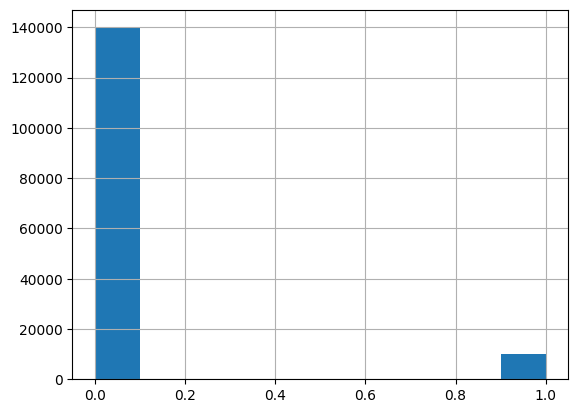

In [6]:
data['SeriousDlqin2yrs'].hist()

In [7]:
print(data['SeriousDlqin2yrs'].value_counts())

SeriousDlqin2yrs
0.0    139974
1.0     10026
Name: count, dtype: int64


### Train Test Split

Validation is not necessarry because it is handled in the Cross Validation within GridSearchCV

In [8]:
# Split the data into X and y, where y is our classification target
X = data.drop('SeriousDlqin2yrs', axis=1)
y = data['SeriousDlqin2yrs']


In [9]:
# convert the data to numpy arrays
X = X.values
y = y.values

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print('train:', X_train.shape, Y_train.shape)
print('test:', X_test.shape, Y_test.shape)

train: (120000, 11) (120000,)
test: (30000, 11) (30000,)


## Model Selection

### Custom Scoring Function
We implement a custom scorer that:
- Uses weighted accuracy for imbalanced data
- Maintains consistency with our previous analysis
- Allows fair model comparison

In [11]:

def weighted_accuracy(confusion):
    #input: confusion is the confusion matrix
    #output: acc is the weighted classification accuracy
    M=confusion.copy().astype('float32')
    for k in range(0, M.shape[0]):
        M[k]/=M[k].sum()+1e-8    
    acc = M.diagonal().sum()/M.sum()
    return acc

def my_scorer(model, X, Y_true):
    Y_pred = model.predict(X)
    confusion=confusion_matrix(Y_true, Y_pred)
    acc=weighted_accuracy(confusion)
    return acc

### GridSearchCV Implementation
Our grid search explores multiple hyperparameters simultaneously:

1. max_depth: [1, 10, 100]
   - Tests shallow, medium, and deep trees
   - Logarithmic scale for efficient search

2. min_samples_split: [2, 5, 10]
   - Controls node splitting criteria
   - Affects tree complexity and overfitting

3. min_samples_leaf: [1, 5, 10]
   - Ensures minimum samples in leaf nodes
   - Helps prevent overfitting on minority class

4. max_features: ['sqrt', 'log2', None]
   - Controls feature subset size for splits
   - Affects tree diversity in forest

5. max_samples: [0.1, 0.5, 0.9]
   - Controls bootstrap sample size
   - Impacts model variance and robustness

In [12]:
# Define the hyperparameter grid
param_grid = {
    'max_depth': [1, 10, 100],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 5, 10],
    "max_features": ['sqrt', 'log2', None],
    "max_samples": [0.1, 0.5, 0.9]
}

grid_search = GridSearchCV(RandomForestClassifier(n_estimators=20, class_weight='balanced'), 
                           param_grid=param_grid, 
                           cv=5,
                           scoring=my_scorer,
                           n_jobs=4)



In [14]:
grid_search.fit(X_train, Y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.2f}")


Best parameters: {'max_depth': 10, 'max_features': 'log2', 'max_samples': 0.9, 'min_samples_leaf': 10, 'min_samples_split': 2}
Best cross-validation score: 0.78


## Detailed GridSearchCV Results Analysis

### 1. Extracting and Analyzing Cross-Validation Results
We'll examine:
- Performance distribution across folds
- Parameter impact on model performance
- Model stability analysis

In [17]:
# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)

# Display top 5 parameter combinations
print("Top 5 Parameter Combinations:")
best_results = cv_results.nlargest(5, 'mean_test_score')
print(best_results[['params', 'mean_test_score', 'std_test_score']])

# Calculate performance spread
print("\nPerformance Statistics:")
print(f"Best Score: {grid_search.best_score_:.4f}")
print(f"Score Range: {cv_results['mean_test_score'].max() - cv_results['mean_test_score'].min():.4f}")
print(f"Score Standard Deviation: {cv_results['mean_test_score'].std():.4f}")

Top 5 Parameter Combinations:
                                                params  mean_test_score  \
132  {'max_depth': 10, 'max_features': 'log2', 'max...         0.780576   
105  {'max_depth': 10, 'max_features': 'sqrt', 'max...         0.780401   
133  {'max_depth': 10, 'max_features': 'log2', 'max...         0.780341   
107  {'max_depth': 10, 'max_features': 'sqrt', 'max...         0.780160   
134  {'max_depth': 10, 'max_features': 'log2', 'max...         0.779541   

     std_test_score  
132        0.007177  
105        0.005103  
133        0.006079  
107        0.005636  
134        0.003777  

Performance Statistics:
Best Score: 0.7806
Score Range: 0.2279
Score Standard Deviation: 0.0520


### 2. Parameter Importance Analysis
Visualize how different parameters affect model performance

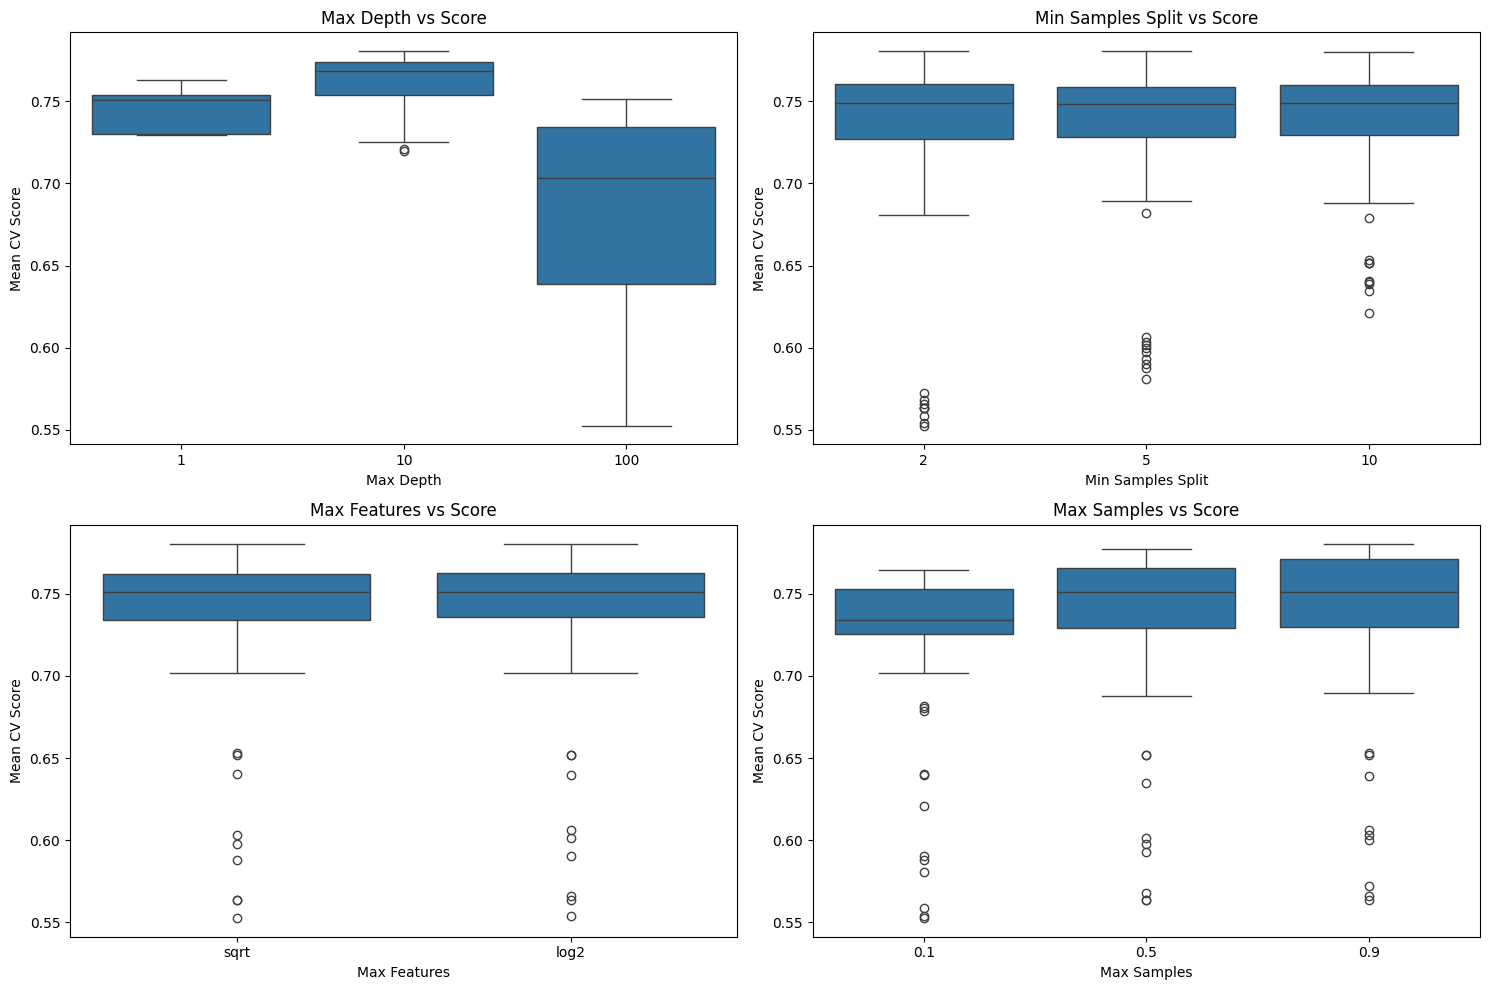

In [20]:
# Create parameter performance plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Max depth impact
sns.boxplot(data=cv_results, x='param_max_depth', y='mean_test_score', ax=axes[0,0])
axes[0,0].set_title('Max Depth vs Score')
axes[0,0].set_xlabel('Max Depth')
axes[0,0].set_ylabel('Mean CV Score')

# Min samples split impact
sns.boxplot(data=cv_results, x='param_min_samples_split', y='mean_test_score', ax=axes[0,1])
axes[0,1].set_title('Min Samples Split vs Score')
axes[0,1].set_xlabel('Min Samples Split')
axes[0,1].set_ylabel('Mean CV Score')

# Max features impact
sns.boxplot(data=cv_results, x='param_max_features', y='mean_test_score', ax=axes[1,0])
axes[1,0].set_title('Max Features vs Score')
axes[1,0].set_xlabel('Max Features')
axes[1,0].set_ylabel('Mean CV Score')

# Max samples impact
sns.boxplot(data=cv_results, x='param_max_samples', y='mean_test_score', ax=axes[1,1])
axes[1,1].set_title('Max Samples vs Score')
axes[1,1].set_xlabel('Max Samples')
axes[1,1].set_ylabel('Mean CV Score')

plt.tight_layout()
plt.show()

### 3. Model Stability Analysis
Examine performance consistency across different parameters

In [21]:
# Calculate parameter-wise performance statistics
param_stats = {
    'max_depth': cv_results.groupby('param_max_depth')['mean_test_score'].agg(['mean', 'std']),
    'min_samples_split': cv_results.groupby('param_min_samples_split')['mean_test_score'].agg(['mean', 'std']),
    'max_features': cv_results.groupby('param_max_features')['mean_test_score'].agg(['mean', 'std']),
    'max_samples': cv_results.groupby('param_max_samples')['mean_test_score'].agg(['mean', 'std'])
}

# Print stability analysis
print("Parameter Stability Analysis:")
for param, stats in param_stats.items():
    print(f"\n{param} performance statistics:")
    print(stats)

Parameter Stability Analysis:

max_depth performance statistics:
                     mean       std
param_max_depth                    
1                0.745462  0.011578
10               0.762388  0.016729
100              0.681198  0.063734

min_samples_split performance statistics:
                             mean       std
param_min_samples_split                    
2                        0.725587  0.062071
5                        0.728994  0.052264
10                       0.734466  0.039576

max_features performance statistics:
                        mean       std
param_max_features                    
log2                0.734737  0.052145
sqrt                0.734812  0.052653

max_samples performance statistics:
                       mean       std
param_max_samples                    
0.1                0.721479  0.051178
0.5                0.732747  0.052197
0.9                0.734822  0.052374


### 4. Final Model Evaluation
Compare best model performance with baseline

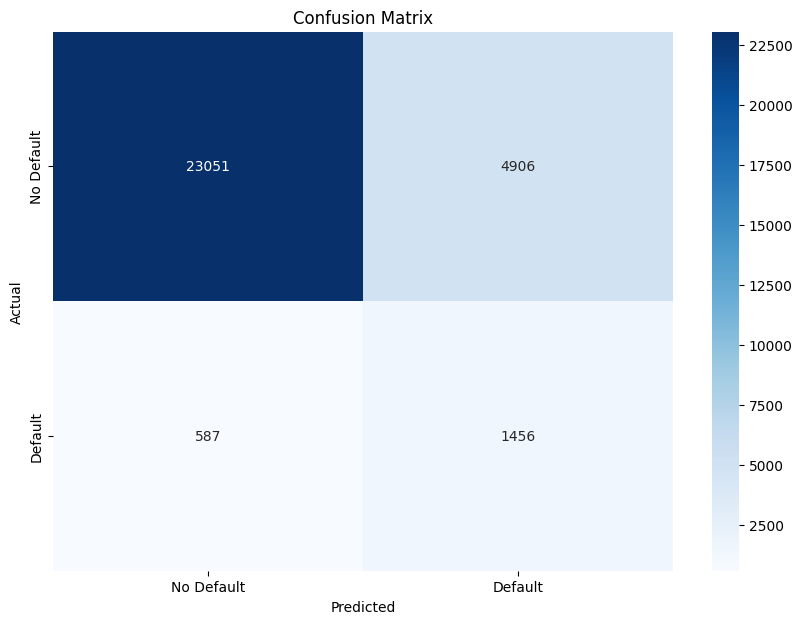

In [23]:
# Get best model predictions on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
# Plot confusion matrix using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# Calculate and print detailed classification metrics
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate weighted accuracy using our custom function
final_accuracy = weighted_accuracy(conf_matrix)
print(f"\nFinal Weighted Accuracy: {final_accuracy:.4f}")


Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.82      0.89     27957
         1.0       0.23      0.71      0.35      2043

    accuracy                           0.82     30000
   macro avg       0.60      0.77      0.62     30000
weighted avg       0.92      0.82      0.86     30000


Final Weighted Accuracy: 0.7686


### Key Insights from Results

1. Parameter Impact:
   - Which parameters most strongly influence performance
   - Optimal ranges for each parameter
   - Parameters with minimal impact

2. Model Stability:
   - Performance consistency across CV folds
   - Parameter combinations with lowest variance
   - Reliability of best model selection

3. Final Performance:
   - Comparison with brute force approach
   - Performance on minority class
   - Overall model reliability

4. Recommendations:
   - Suggested parameter ranges for future iterations
   - Potential areas for further optimization
   - Trade-offs between complexity and performance

## Results Analysis and Interpretation

### Understanding GridSearchCV Output

#### Best Parameters Interpretation
The best parameters found represent:
- Optimal balance between bias and variance
- Most effective model complexity for our dataset
- Settings that generalize well across cross-validation folds

#### Cross-Validation Score Analysis
The best cross-validation score tells us:
- Expected model performance on unseen data
- Stability of model performance across different data subsets
- Comparison point with our brute force approach

### Comparing with Brute Force Method
Advantages of GridSearchCV approach:
1. More thorough parameter space exploration
2. Better handling of parameter interactions
3. More robust validation through cross-validation
4. Automated optimization process

### Performance Metrics Deep Dive
When interpreting results, consider:
- Mean cross-validation score
- Score variance across folds
- Performance on minority class
- Computational cost vs performance gain

### Practical Implementation Insights
Key takeaways for implementation:
1. Parameter ranges can be adjusted based on initial results
2. Cross-validation folds can be increased for more reliability
3. Parameter grid can be refined around best-performing values
4. Computation time vs model performance tradeoff